# Version 5 Notes:

* Made original testing set
* Validation/training still come from augmented set
* Testing set has heavy class imbalance (this doesnt affect training though)
* Implemented weights for evaluation on testing bc of class imbalance


In [20]:
! pip install tensorflow
! pip install kagglehub
! pip install psutil
! pip install matplotlib
%pip install scikit-learn
%pip install imbalanced-learn
! pip install pandas
! pip install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip in

In [21]:
import os
import warnings
warnings.filterwarnings("ignore")

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from pathlib import Path
import os.path

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Setting Paths

In [24]:
# importing the data
import kagglehub

# download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset") # directory path

print("Path to dataset files:", path)

base_path = path  # this path comes from the API

train_dir = os.path.join(base_path, 'AugmentedAlzheimerDataset') # subdirectory (AugmentedAlzheimerDataset) inside the base path
test_dir = os.path.join(base_path, 'OriginalDataset')

# printing the directories to verify
print("Train Directory:", train_dir) # path to the training directory
print("Test Directory:", test_dir)    # Testing directory

Path to dataset files: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1
Train Directory: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/AugmentedAlzheimerDataset
Test Directory: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/OriginalDataset


In [25]:
image_dir = Path(train_dir)

# get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) # list contains all image file paths in the directory

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths)) # list will now contain labels for each image file, based on the directory names

filepaths = pd.Series(filepaths, name='Filepath').astype(str)  # converted into a Pandas Series  and cast to string type to ensure compatibility when working with the DataFrame
labels = pd.Series(labels, name='Label') # also converted into a Pandas series

# concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1) # pd.concat() concatenates the filepaths and labels Series along the column axis to create a DataFrame named image_df.

In [26]:
# identify and print out the paths of any .jpg images within base_path that cannot be opened due to being unrecognized or corrupted.
# For quality-checking the dataset and ensuring all images are valid before processing them
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(base_path).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [27]:
image_df

,Filepath,Label
0,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
1,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
2,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
3,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
4,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
...,...,...
33979,/home/gitpod/.cache/kagglehub/datasets/uraninj...,VeryMildDemented
33980,/home/gitpod/.cache/kagglehub/datasets/uraninj...,VeryMildDemented
33981,/home/gitpod/.cache/kagglehub/datasets/uraninj...,VeryMildDemented
33982,/home/gitpod/.cache/kagglehub/datasets/uraninj...,VeryMildDemented


In [28]:
image_df.shape

(33984, 2)

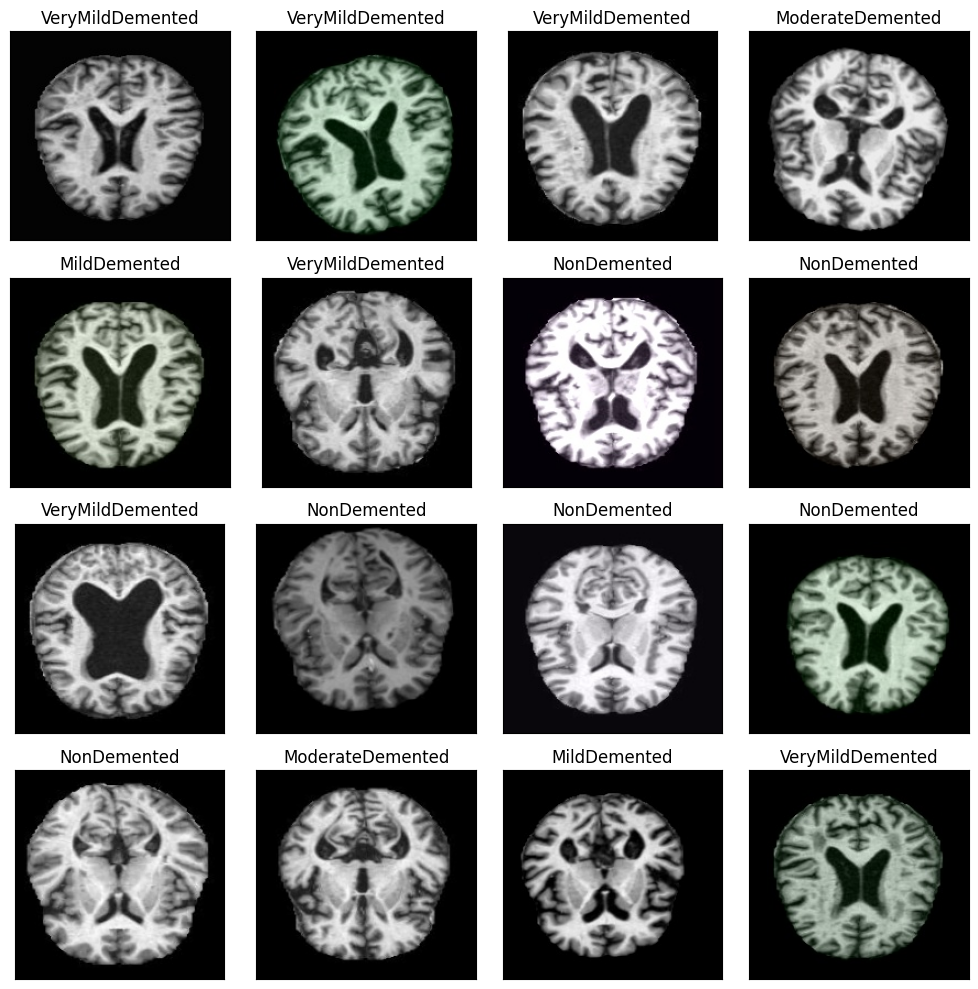

In [29]:
#  randomly select 16 images from image_df and displays them in a 4x4 grid with their labels as titles.
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Rescaling, Resizing, and Train/Test/Validation Splits

In [30]:
# sets up two data generators, one for training and one for validation, which will load, resize, and preprocess images from the  directory (train_dir).
# The images are rescaled, organized into batches, and split into training and validation sets to be used in model training.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# generates batches of image data with real-time data augmentation. It allows the images to be loaded and preprocessed in real-time

train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation

train_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resizes each image to 224x224 pixels
    batch_size=32, # the generator will yield batches of 32 images at a time
    class_mode='categorical', # labels are categorical, meaning the generator will one-hot encode the labels.
    subset='training', # specifies that this generator will use the 80% subset for training
    shuffle = True) # shuffle the dataset to promote model generalization

validation_images = train_datagen.flow_from_directory(
    train_dir ,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # specified to use the 20% of the images allocated for validation
    shuffle = False) # do no shuffle to keep consistent evaluation order

# Original dataset for testing
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for testing

test_images = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for consistent evaluation
)

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [31]:
true_classes = validation_images.classes

In [32]:
print(len(train_images))
print(len(validation_images))

850
213


# Check Class Distribution

In [33]:
# Print unique class labels and their counts
import collections

class_counts = collections.Counter(train_images.classes)
print("Class Distribution in Training Set:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count}")

class_counts_validation = collections.Counter(validation_images.classes)
print("\nClass Distribution in Validation Set:")
for class_label, count in class_counts_validation.items():
    print(f"Class {class_label}: {count}")

class_counts_test = collections.Counter(test_images.classes)
print("\nClass Distribution in Validation Set:")
for class_label, count in class_counts_test.items():
    print(f"Class {class_label}: {count}")


Class Distribution in Training Set:
Class 0: 7168
Class 1: 5172
Class 2: 7680
Class 3: 7168

Class Distribution in Validation Set:
Class 0: 1792
Class 1: 1292
Class 2: 1920
Class 3: 1792

Class Distribution in Validation Set:
Class 0: 896
Class 1: 64
Class 2: 3200
Class 3: 2240


Training Data Distribution: {'MildDemented': 7168, 'ModerateDemented': 5172, 'NonDemented': 7680, 'VeryMildDemented': 7168}
Validation Data Distribution: {'MildDemented': 1792, 'ModerateDemented': 1292, 'NonDemented': 1920, 'VeryMildDemented': 1792}
Testing Data Distribution: {'MildDemented': 896, 'ModerateDemented': 64, 'NonDemented': 3200, 'VeryMildDemented': 2240}


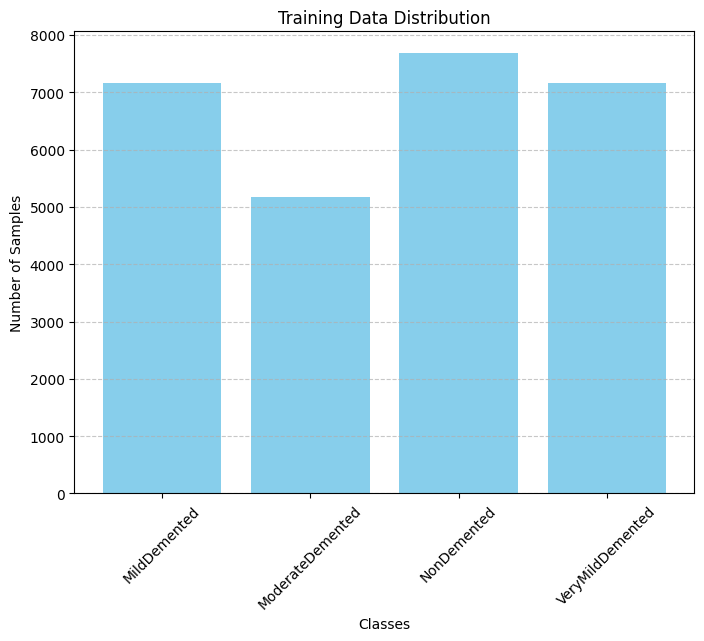

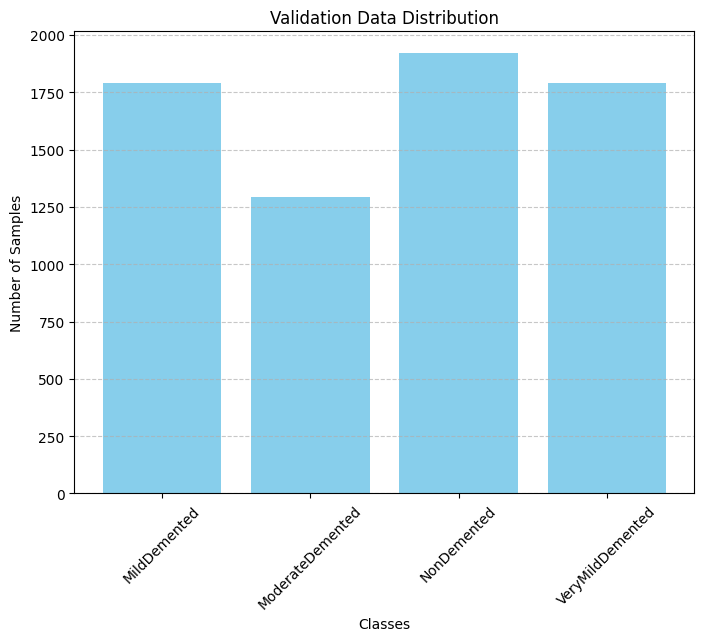

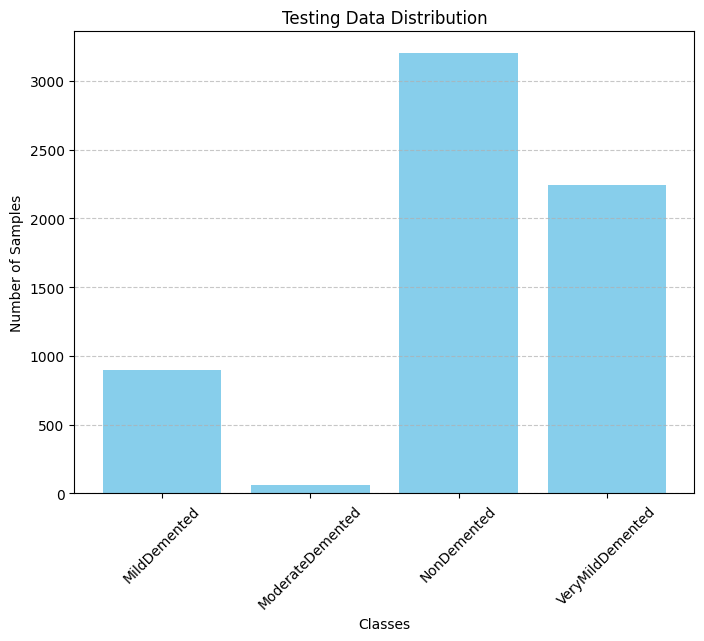

In [34]:
from collections import Counter

# Training set
train_distribution = dict(Counter(train_images.classes))
train_distribution = {key: train_distribution[value] for key, value in train_images.class_indices.items()}

# Validation set
val_distribution = dict(Counter(validation_images.classes))
val_distribution = {key: val_distribution[value] for key, value in validation_images.class_indices.items()}

# Testing set
test_distribution = dict(Counter(test_images.classes))
test_distribution = {key: test_distribution[value] for key, value in test_images.class_indices.items()}

# Print distributions to verify
print("Training Data Distribution:", train_distribution)
print("Validation Data Distribution:", val_distribution)
print("Testing Data Distribution:", test_distribution)


import matplotlib.pyplot as plt

# Function to plot class distributions
def plot_class_distributions(distributions, title):
    plt.figure(figsize=(8, 6))
    plt.bar(distributions.keys(), distributions.values(), color='skyblue')
    plt.title(title)
    plt.ylabel("Number of Samples")
    plt.xlabel("Classes")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot distributions
plot_class_distributions(train_distribution, "Training Data Distribution")
plot_class_distributions(val_distribution, "Validation Data Distribution")
plot_class_distributions(test_distribution, "Testing Data Distribution")


# Class Weights to Testing Evaluation

In [37]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights for testing dataset
test_labels = test_images.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(test_labels), y=test_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print class weights
print("Class Weights for Testing Dataset:", class_weights_dict)

Class Weights for Testing Dataset: {0: np.float64(1.7857142857142858), 1: np.float64(25.0), 2: np.float64(0.5), 3: np.float64(0.7142857142857143)}


# Dictionary to store histories and evaluation metrics

In [38]:
# Dictionary to store histories and evaluation metrics
histories = {}
evaluation_metrics = {}

# Model 1: Basic CNN

In [39]:
# Model 1: Basic CNN
print("\nTraining Model 1: Basic CNN")
model_1 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')
])
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 1'] = history_1


Training Model 1: Basic CNN


2024-11-18 07:35:09.505727: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 1032s 1s/step - accuracy: 0.5186 - loss: 1.0263 - val_accuracy: 0.7172 - val_loss: 0.6096
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 1059s 1s/step - accuracy: 0.7675 - loss: 0.5325 - val_accuracy: 0.8081 - val_loss: 0.4465
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 1044s 1s/step - accuracy: 0.8600 - loss: 0.3391 - val_accuracy: 0.8799 - val_loss: 0.2895
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 1212s 1s/step - accuracy: 0.9095 - loss: 0.2276 - val_accuracy: 0.8873 - val_loss: 0.2842
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 1115s 1s/step - accuracy: 0.9378 - loss: 0.1548 - val_accuracy: 0.9036 - val_loss: 0.2525
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 1184s 1s/step - accuracy: 0.9600 - loss: 0.1116 - val_accuracy: 0.9014 - val_loss: 0.3009
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 1172s 1s/step - accuracy: 0.9694 - loss: 0.0834 - val_accuracy: 0.9117 - val_loss: 0.2706
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 1139s 1s/step - accuracy: 0.9742 - loss: 0.0702 - 

Class Weights for Testing Dataset: {0: np.float64(1.7857142857142858), 1: np.float64(25.0), 2: np.float64(0.5), 3: np.float64(0.7142857142857143)}

Evaluating Model 1 on the Testing Dataset (Unweighted)
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 301ms/step - accuracy: 0.9891 - loss: 0.0373
Test Loss (Unweighted): 0.04008490592241287
Test Accuracy (Unweighted): 0.98828125
200/200 ━━━━━━━━━━━━━━━━━━━━ 56s 281ms/step

Evaluating Model 1 on the Testing Dataset (Weighted)
200/200 ━━━━━━━━━━━━━━━━━━━━ 56s 278ms/step
Manually Computed Weighted Accuracy: 0.9929352678571428


<Figure size 800x800 with 0 Axes>

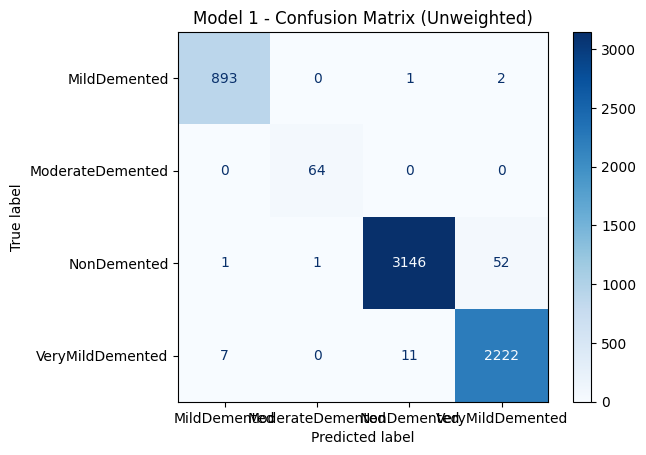

<Figure size 800x800 with 0 Axes>

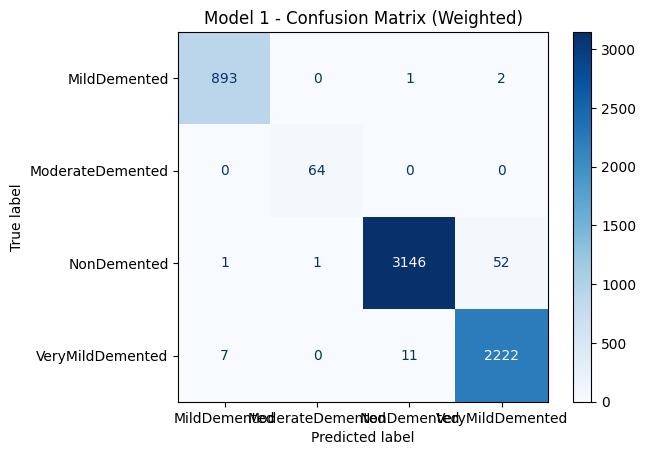

Model 1 - Classification Report (Unweighted):
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99       896
ModerateDemented       0.98      1.00      0.99        64
     NonDemented       1.00      0.98      0.99      3200
VeryMildDemented       0.98      0.99      0.98      2240

        accuracy                           0.99      6400
       macro avg       0.99      0.99      0.99      6400
    weighted avg       0.99      0.99      0.99      6400

Model 1 - Classification Report (Weighted):
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99       896
ModerateDemented       0.98      1.00      0.99        64
     NonDemented       1.00      0.98      0.99      3200
VeryMildDemented       0.98      0.99      0.98      2240

        accuracy                           0.99      6400
       macro avg       0.99      0.99      0.99      6400
    weighted avg       0.99      0.

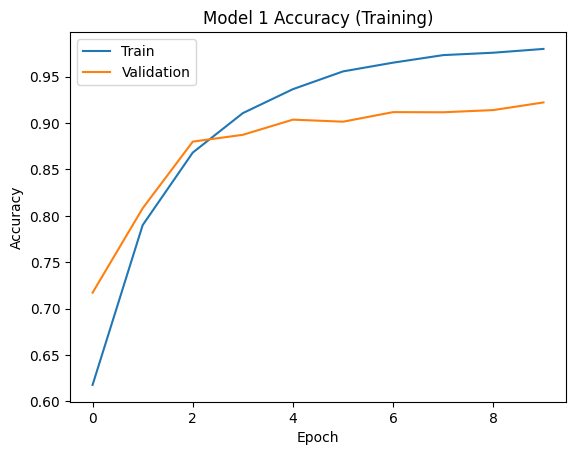

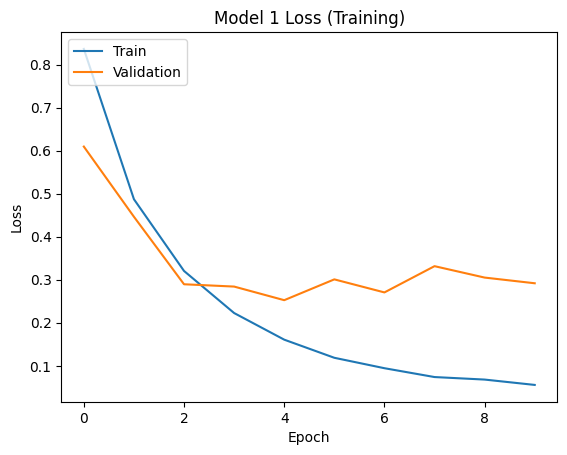

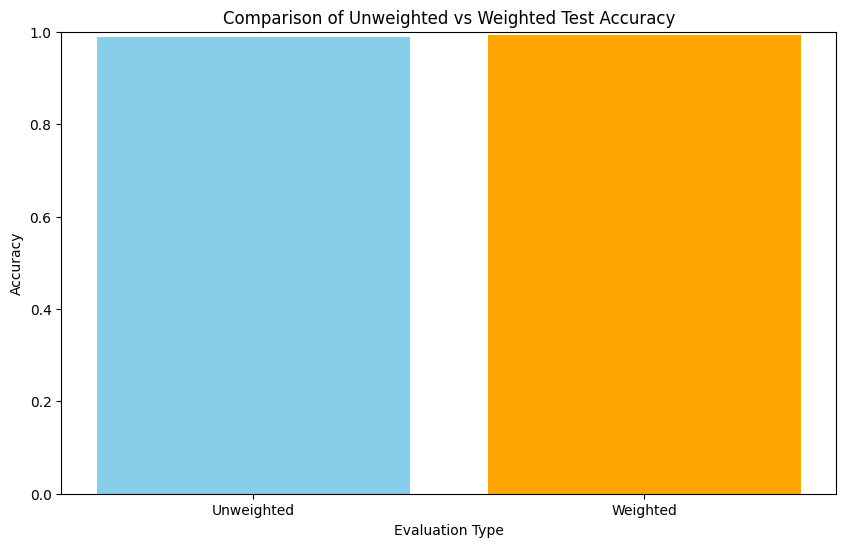

In [41]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# --- Compute Class Weights for the Testing Dataset ---
test_labels = test_images.classes  # Get the class labels from the test dataset
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(test_labels), y=test_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print class weights for reference
print("Class Weights for Testing Dataset:", class_weights_dict)

# --- Compute Sample Weights for the Testing Dataset ---
sample_weights = compute_sample_weight(class_weight='balanced', y=test_labels)

# --- Unweighted Evaluation ---
print("\nEvaluating Model 1 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted, test_accuracy_unweighted = model_1.evaluate(
    test_images, 
    steps=len(test_images),
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted}")

# Generate Predictions for Unweighted Metrics
predictions_unweighted = model_1.predict(test_images)
predicted_classes_unweighted = np.argmax(predictions_unweighted, axis=1)

# --- Weighted Evaluation (Manual Calculation) ---
print("\nEvaluating Model 1 on the Testing Dataset (Weighted)")

# Generate predictions
predictions_weighted = model_1.predict(test_images)
predicted_classes_weighted = np.argmax(predictions_weighted, axis=1)

# Manually calculate weighted accuracy
accuracy_weighted = np.sum((predicted_classes_weighted == test_labels) * sample_weights) / np.sum(sample_weights)

print(f"Manually Computed Weighted Accuracy: {accuracy_weighted}")

# --- Unweighted Confusion Matrix ---
cm_unweighted = confusion_matrix(test_images.classes, predicted_classes_unweighted)
disp_unweighted = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 1 - Confusion Matrix (Unweighted)")
plt.show()

# --- Weighted Confusion Matrix ---
cm_weighted = confusion_matrix(test_images.classes, predicted_classes_weighted)
disp_weighted = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 1 - Confusion Matrix (Weighted)")
plt.show()

# --- Unweighted Classification Report ---
report_unweighted = classification_report(
    test_images.classes, 
    predicted_classes_unweighted, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle any undefined metrics
)
print("Model 1 - Classification Report (Unweighted):")
print(report_unweighted)

# --- Weighted Classification Report ---
report_weighted = classification_report(
    test_images.classes, 
    predicted_classes_weighted, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle any undefined metrics
)
print("Model 1 - Classification Report (Weighted):")
print(report_weighted)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 1 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted,
    'classification_report': report_unweighted,
    'confusion_matrix': cm_unweighted
}

evaluation_metrics['Model 1 (Weighted)'] = {
    'accuracy': accuracy_weighted,
    'classification_report': report_weighted,
    'confusion_matrix': cm_weighted
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics")
print(f"Unweighted Accuracy: {test_accuracy_unweighted}")
print(f"Weighted Accuracy: {accuracy_weighted}")

# --- Plot Training Accuracy and Loss ---
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model 1 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted, accuracy_weighted], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()



# Model 2: CNN + L2 Regularization

In [ ]:
# Model 2: CNN + L2 Regularization
print("\nTraining Model 2: CNN + L2 Regularization")
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(224, 224, 3)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.5))

model_2.add(layers.Dense(4, activation='softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 2'] = history_2


Training Model 2: CNN + L2 Regularization
Epoch 1/10
304/850 ━━━━━━━━━━━━━━━━━━━━ 47:52 5s/step - accuracy: 0.4365 - loss: 2.0976

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Unweighted Evaluation ---
print("\nEvaluating Model 2 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted_2, test_accuracy_unweighted_2 = model_2.evaluate(
    test_images, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted_2}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted_2}")

# Generate predictions for unweighted metrics
predictions_unweighted_2 = model_2.predict(test_images)
predicted_classes_unweighted_2 = np.argmax(predictions_unweighted_2, axis=1)

# --- Weighted Evaluation (Manual Calculation) ---
print("\nEvaluating Model 2 on the Testing Dataset (Weighted)")

# Compute sample weights for the testing dataset
test_labels = test_images.classes
sample_weights_2 = compute_sample_weight(class_weight='balanced', y=test_labels)

# Generate predictions for weighted metrics
predictions_weighted_2 = model_2.predict(test_images)
predicted_classes_weighted_2 = np.argmax(predictions_weighted_2, axis=1)

# Manually calculate weighted accuracy
accuracy_weighted_2 = np.sum((predicted_classes_weighted_2 == test_labels) * sample_weights_2) / np.sum(sample_weights_2)
print(f"Manually Computed Weighted Accuracy: {accuracy_weighted_2}")

# --- Confusion Matrix (Unweighted) ---
cm_unweighted_2 = confusion_matrix(test_images.classes, predicted_classes_unweighted_2)
disp_unweighted_2 = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted_2, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted_2.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 2 - Confusion Matrix (Unweighted)")
plt.show()

# --- Confusion Matrix (Weighted) ---
cm_weighted_2 = confusion_matrix(test_images.classes, predicted_classes_weighted_2)
disp_weighted_2 = ConfusionMatrixDisplay(confusion_matrix=cm_weighted_2, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted_2.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 2 - Confusion Matrix (Weighted)")
plt.show()

# --- Classification Report (Unweighted) ---
report_unweighted_2 = classification_report(
    test_images.classes, 
    predicted_classes_unweighted_2, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 2 - Classification Report (Unweighted):")
print(report_unweighted_2)

# --- Classification Report (Weighted) ---
report_weighted_2 = classification_report(
    test_images.classes, 
    predicted_classes_weighted_2, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 2 - Classification Report (Weighted):")
print(report_weighted_2)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 2 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted_2,
    'classification_report': report_unweighted_2,
    'confusion_matrix': cm_unweighted_2,
    'history': history_2.history
}

evaluation_metrics['Model 2 (Weighted)'] = {
    'accuracy': accuracy_weighted_2,
    'classification_report': report_weighted_2,
    'confusion_matrix': cm_weighted_2,
    'history': history_2.history
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics for Model 2")
print(f"Unweighted Accuracy: {test_accuracy_unweighted_2}")
print(f"Weighted Accuracy: {accuracy_weighted_2}")

# --- Plot Training Accuracy and Loss ---
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model 2 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model 2 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted_2, accuracy_weighted_2], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy for Model 2")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()



# Model 3: CNN + BatchNormalization

In [ ]:
# Model 3: CNN + BatchNormalization
print("\nTraining Model 3: CNN + BatchNormalization")
model_3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 3'] = history_3

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Unweighted Evaluation ---
print("\nEvaluating Model 3 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted_3, test_accuracy_unweighted_3 = model_3.evaluate(
    test_images, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted_3}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted_3}")

# Generate predictions for unweighted metrics
predictions_unweighted_3 = model_3.predict(test_images)
predicted_classes_unweighted_3 = np.argmax(predictions_unweighted_3, axis=1)

# --- Weighted Evaluation ---
print("\nEvaluating Model 3 on the Testing Dataset (Weighted)")

# Compute sample weights for the testing dataset
test_labels = test_images.classes
sample_weights_3 = compute_sample_weight(class_weight='balanced', y=test_labels)

# Evaluate using sample weights
test_loss_weighted_3, test_accuracy_weighted_3 = model_3.evaluate(
    test_images, 
    sample_weight=sample_weights_3, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Weighted): {test_loss_weighted_3}")
print(f"Test Accuracy (Weighted): {test_accuracy_weighted_3}")

# Generate predictions for weighted metrics
predictions_weighted_3 = model_3.predict(test_images)
predicted_classes_weighted_3 = np.argmax(predictions_weighted_3, axis=1)

# --- Confusion Matrix (Unweighted) ---
cm_unweighted_3 = confusion_matrix(test_images.classes, predicted_classes_unweighted_3)
disp_unweighted_3 = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted_3, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted_3.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 3 - Confusion Matrix (Unweighted)")
plt.show()

# --- Confusion Matrix (Weighted) ---
cm_weighted_3 = confusion_matrix(test_images.classes, predicted_classes_weighted_3)
disp_weighted_3 = ConfusionMatrixDisplay(confusion_matrix=cm_weighted_3, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted_3.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 3 - Confusion Matrix (Weighted)")
plt.show()

# --- Classification Report (Unweighted) ---
report_unweighted_3 = classification_report(
    test_images.classes, 
    predicted_classes_unweighted_3, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 3 - Classification Report (Unweighted):")
print(report_unweighted_3)

# --- Classification Report (Weighted) ---
report_weighted_3 = classification_report(
    test_images.classes, 
    predicted_classes_weighted_3, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 3 - Classification Report (Weighted):")
print(report_weighted_3)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 3 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted_3,
    'classification_report': report_unweighted_3,
    'confusion_matrix': cm_unweighted_3,
    'history': history_3.history
}

evaluation_metrics['Model 3 (Weighted)'] = {
    'accuracy': test_accuracy_weighted_3,
    'classification_report': report_weighted_3,
    'confusion_matrix': cm_weighted_3,
    'history': history_3.history
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics for Model 3")
print(f"Unweighted Accuracy: {test_accuracy_unweighted_3}")
print(f"Weighted Accuracy: {test_accuracy_weighted_3}")

# --- Plot Training Accuracy and Loss ---
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model 3 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model 3 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted_3, test_accuracy_weighted_3], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy for Model 3")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()


# Model 4: CNN + L2 + BatchNormalization

In [ ]:
print("\nTraining Model 4: CNN + L2 + BatchNormalization")
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(224, 224, 3)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dropout(0.5))
model_4.add(layers.Dense(4, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_4 = model_4.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 4'] = history_4

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Unweighted Evaluation ---
print("\nEvaluating Model 4 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted_4, test_accuracy_unweighted_4 = model_4.evaluate(
    test_images, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted_4}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted_4}")

# Generate predictions for unweighted metrics
predictions_unweighted_4 = model_4.predict(test_images)
predicted_classes_unweighted_4 = np.argmax(predictions_unweighted_4, axis=1)

# --- Weighted Evaluation ---
print("\nEvaluating Model 4 on the Testing Dataset (Weighted)")

# Compute sample weights for the testing dataset
test_labels = test_images.classes
sample_weights_4 = compute_sample_weight(class_weight='balanced', y=test_labels)

# Evaluate using sample weights
test_loss_weighted_4, test_accuracy_weighted_4 = model_4.evaluate(
    test_images, 
    sample_weight=sample_weights_4, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Weighted): {test_loss_weighted_4}")
print(f"Test Accuracy (Weighted): {test_accuracy_weighted_4}")

# Generate predictions for weighted metrics
predictions_weighted_4 = model_4.predict(test_images)
predicted_classes_weighted_4 = np.argmax(predictions_weighted_4, axis=1)

# --- Confusion Matrix (Unweighted) ---
cm_unweighted_4 = confusion_matrix(test_images.classes, predicted_classes_unweighted_4)
disp_unweighted_4 = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted_4, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted_4.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 4 - Confusion Matrix (Unweighted)")
plt.show()

# --- Confusion Matrix (Weighted) ---
cm_weighted_4 = confusion_matrix(test_images.classes, predicted_classes_weighted_4)
disp_weighted_4 = ConfusionMatrixDisplay(confusion_matrix=cm_weighted_4, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted_4.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 4 - Confusion Matrix (Weighted)")
plt.show()

# --- Classification Report (Unweighted) ---
report_unweighted_4 = classification_report(
    test_images.classes, 
    predicted_classes_unweighted_4, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 4 - Classification Report (Unweighted):")
print(report_unweighted_4)

# --- Classification Report (Weighted) ---
report_weighted_4 = classification_report(
    test_images.classes, 
    predicted_classes_weighted_4, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 4 - Classification Report (Weighted):")
print(report_weighted_4)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 4 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted_4,
    'classification_report': report_unweighted_4,
    'confusion_matrix': cm_unweighted_4,
    'history': history_4.history
}

evaluation_metrics['Model 4 (Weighted)'] = {
    'accuracy': test_accuracy_weighted_4,
    'classification_report': report_weighted_4,
    'confusion_matrix': cm_weighted_4,
    'history': history_4.history
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics for Model 4")
print(f"Unweighted Accuracy: {test_accuracy_unweighted_4}")
print(f"Weighted Accuracy: {test_accuracy_weighted_4}")

# --- Plot Training Accuracy and Loss ---
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model 4 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model 4 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted_4, test_accuracy_weighted_4], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy for Model 4")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()


# Model 5: CNN + Dropout

In [ ]:
print("\nTraining Model 5: CNN + Dropout")
model_5 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_5 = model_5.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 5'] = history_5

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Unweighted Evaluation ---
print("\nEvaluating Model 5 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted_5, test_accuracy_unweighted_5 = model_5.evaluate(
    test_images, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted_5}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted_5}")

# Generate predictions for unweighted metrics
predictions_unweighted_5 = model_5.predict(test_images)
predicted_classes_unweighted_5 = np.argmax(predictions_unweighted_5, axis=1)

# --- Weighted Evaluation ---
print("\nEvaluating Model 5 on the Testing Dataset (Weighted)")

# Compute sample weights for the testing dataset
test_labels = test_images.classes
sample_weights_5 = compute_sample_weight(class_weight='balanced', y=test_labels)

# Evaluate using sample weights
test_loss_weighted_5, test_accuracy_weighted_5 = model_5.evaluate(
    test_images, 
    sample_weight=sample_weights_5, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Weighted): {test_loss_weighted_5}")
print(f"Test Accuracy (Weighted): {test_accuracy_weighted_5}")

# Generate predictions for weighted metrics
predictions_weighted_5 = model_5.predict(test_images)
predicted_classes_weighted_5 = np.argmax(predictions_weighted_5, axis=1)

# --- Confusion Matrix (Unweighted) ---
cm_unweighted_5 = confusion_matrix(test_images.classes, predicted_classes_unweighted_5)
disp_unweighted_5 = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted_5, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted_5.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 5 - Confusion Matrix (Unweighted)")
plt.show()

# --- Confusion Matrix (Weighted) ---
cm_weighted_5 = confusion_matrix(test_images.classes, predicted_classes_weighted_5)
disp_weighted_5 = ConfusionMatrixDisplay(confusion_matrix=cm_weighted_5, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted_5.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 5 - Confusion Matrix (Weighted)")
plt.show()

# --- Classification Report (Unweighted) ---
report_unweighted_5 = classification_report(
    test_images.classes, 
    predicted_classes_unweighted_5, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 5 - Classification Report (Unweighted):")
print(report_unweighted_5)

# --- Classification Report (Weighted) ---
report_weighted_5 = classification_report(
    test_images.classes, 
    predicted_classes_weighted_5, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 5 - Classification Report (Weighted):")
print(report_weighted_5)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 5 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted_5,
    'classification_report': report_unweighted_5,
    'confusion_matrix': cm_unweighted_5,
    'history': history_5.history
}

evaluation_metrics['Model 5 (Weighted)'] = {
    'accuracy': test_accuracy_weighted_5,
    'classification_report': report_weighted_5,
    'confusion_matrix': cm_weighted_5,
    'history': history_5.history
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics for Model 5")
print(f"Unweighted Accuracy: {test_accuracy_unweighted_5}")
print(f"Weighted Accuracy: {test_accuracy_weighted_5}")

# --- Plot Training Accuracy and Loss ---
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model 5 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model 5 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted_5, test_accuracy_weighted_5], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy for Model 5")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()


# Model 6: CNN + EarlyStopping

In [ ]:
print("\nTraining Model 6: CNN + EarlyStopping")
model_6 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_6 = EarlyStopping(monitor='val_loss', patience=3)
history_6 = model_6.fit(train_images, validation_data=validation_images, epochs=10, callbacks=[early_stopping_6])
histories['Model 6'] = history_6

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Unweighted Evaluation ---
print("\nEvaluating Model 6 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted_6, test_accuracy_unweighted_6 = model_6.evaluate(
    test_images, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted_6}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted_6}")

# Generate predictions for unweighted metrics
predictions_unweighted_6 = model_6.predict(test_images)
predicted_classes_unweighted_6 = np.argmax(predictions_unweighted_6, axis=1)

# --- Weighted Evaluation ---
print("\nEvaluating Model 6 on the Testing Dataset (Weighted)")

# Compute sample weights for the testing dataset
test_labels = test_images.classes
sample_weights_6 = compute_sample_weight(class_weight='balanced', y=test_labels)

# Evaluate using sample weights
test_loss_weighted_6, test_accuracy_weighted_6 = model_6.evaluate(
    test_images, 
    sample_weight=sample_weights_6, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Weighted): {test_loss_weighted_6}")
print(f"Test Accuracy (Weighted): {test_accuracy_weighted_6}")

# Generate predictions for weighted metrics
predictions_weighted_6 = model_6.predict(test_images)
predicted_classes_weighted_6 = np.argmax(predictions_weighted_6, axis=1)

# --- Confusion Matrix (Unweighted) ---
cm_unweighted_6 = confusion_matrix(test_images.classes, predicted_classes_unweighted_6)
disp_unweighted_6 = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted_6, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted_6.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 6 - Confusion Matrix (Unweighted)")
plt.show()

# --- Confusion Matrix (Weighted) ---
cm_weighted_6 = confusion_matrix(test_images.classes, predicted_classes_weighted_6)
disp_weighted_6 = ConfusionMatrixDisplay(confusion_matrix=cm_weighted_6, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted_6.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 6 - Confusion Matrix (Weighted)")
plt.show()

# --- Classification Report (Unweighted) ---
report_unweighted_6 = classification_report(
    test_images.classes, 
    predicted_classes_unweighted_6, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 6 - Classification Report (Unweighted):")
print(report_unweighted_6)

# --- Classification Report (Weighted) ---
report_weighted_6 = classification_report(
    test_images.classes, 
    predicted_classes_weighted_6, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 6 - Classification Report (Weighted):")
print(report_weighted_6)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 6 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted_6,
    'classification_report': report_unweighted_6,
    'confusion_matrix': cm_unweighted_6,
    'history': history_6.history
}

evaluation_metrics['Model 6 (Weighted)'] = {
    'accuracy': test_accuracy_weighted_6,
    'classification_report': report_weighted_6,
    'confusion_matrix': cm_weighted_6,
    'history': history_6.history
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics for Model 6")
print(f"Unweighted Accuracy: {test_accuracy_unweighted_6}")
print(f"Weighted Accuracy: {test_accuracy_weighted_6}")

# --- Plot Training Accuracy and Loss ---
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model 6 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('Model 6 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted_6, test_accuracy_weighted_6], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy for Model 6")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()


# Model 7: CNN + ReduceLROnPlateau

In [ ]:
print("\nTraining Model 7: CNN + ReduceLROnPlateau")
model_7 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr_7 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
history_7 = model_7.fit(train_images, validation_data=validation_images, epochs=10, callbacks=[reduce_lr_7])
histories['Model 7'] = history_7

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Unweighted Evaluation ---
print("\nEvaluating Model 7 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted_7, test_accuracy_unweighted_7 = model_7.evaluate(
    test_images, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted_7}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted_7}")

# Generate predictions for unweighted metrics
predictions_unweighted_7 = model_7.predict(test_images)
predicted_classes_unweighted_7 = np.argmax(predictions_unweighted_7, axis=1)

# --- Weighted Evaluation ---
print("\nEvaluating Model 7 on the Testing Dataset (Weighted)")

# Compute sample weights for the testing dataset
test_labels = test_images.classes
sample_weights_7 = compute_sample_weight(class_weight='balanced', y=test_labels)

# Evaluate using sample weights
test_loss_weighted_7, test_accuracy_weighted_7 = model_7.evaluate(
    test_images, 
    sample_weight=sample_weights_7, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Weighted): {test_loss_weighted_7}")
print(f"Test Accuracy (Weighted): {test_accuracy_weighted_7}")

# Generate predictions for weighted metrics
predictions_weighted_7 = model_7.predict(test_images)
predicted_classes_weighted_7 = np.argmax(predictions_weighted_7, axis=1)

# --- Confusion Matrix (Unweighted) ---
cm_unweighted_7 = confusion_matrix(test_images.classes, predicted_classes_unweighted_7)
disp_unweighted_7 = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted_7, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted_7.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 7 - Confusion Matrix (Unweighted)")
plt.show()

# --- Confusion Matrix (Weighted) ---
cm_weighted_7 = confusion_matrix(test_images.classes, predicted_classes_weighted_7)
disp_weighted_7 = ConfusionMatrixDisplay(confusion_matrix=cm_weighted_7, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted_7.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 7 - Confusion Matrix (Weighted)")
plt.show()

# --- Classification Report (Unweighted) ---
report_unweighted_7 = classification_report(
    test_images.classes, 
    predicted_classes_unweighted_7, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 7 - Classification Report (Unweighted):")
print(report_unweighted_7)

# --- Classification Report (Weighted) ---
report_weighted_7 = classification_report(
    test_images.classes, 
    predicted_classes_weighted_7, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 7 - Classification Report (Weighted):")
print(report_weighted_7)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 7 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted_7,
    'classification_report': report_unweighted_7,
    'confusion_matrix': cm_unweighted_7,
    'history': history_7.history
}

evaluation_metrics['Model 7 (Weighted)'] = {
    'accuracy': test_accuracy_weighted_7,
    'classification_report': report_weighted_7,
    'confusion_matrix': cm_weighted_7,
    'history': history_7.history
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics for Model 7")
print(f"Unweighted Accuracy: {test_accuracy_unweighted_7}")
print(f"Weighted Accuracy: {test_accuracy_weighted_7}")

# --- Plot Training Accuracy and Loss ---
plt.plot(history_7.history['accuracy'])
plt.plot(history_7.history['val_accuracy'])
plt.title('Model 7 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('Model 7 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted_7, test_accuracy_weighted_7], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy for Model 7")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()


# Model 9 (OG)

In [ ]:
# Model 9 (Original)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D

# model architecture
model_9 = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'), #  fully connected layer with 512 units
    Dropout(0.2), # drops 20% of the neurons in this layer during training
    Dense(4, activation = 'softmax') # softmax for multi class
])

model_9.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_9 = model_9.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

histories['Model 9'] = history_9

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 32)        0

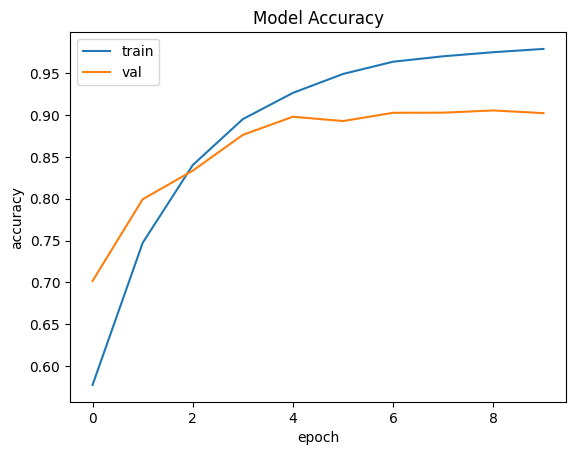

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Unweighted Evaluation ---
print("\nEvaluating Model 9 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted_9, test_accuracy_unweighted_9 = model_9.evaluate(
    test_images, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted_9}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted_9}")

# Generate predictions for unweighted metrics
predictions_unweighted_9 = model_9.predict(test_images)
predicted_classes_unweighted_9 = np.argmax(predictions_unweighted_9, axis=1)

# --- Weighted Evaluation ---
print("\nEvaluating Model 9 on the Testing Dataset (Weighted)")

# Compute sample weights for the testing dataset
test_labels = test_images.classes
sample_weights_9 = compute_sample_weight(class_weight='balanced', y=test_labels)

# Evaluate using sample weights
test_loss_weighted_9, test_accuracy_weighted_9 = model_9.evaluate(
    test_images, 
    sample_weight=sample_weights_9, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Weighted): {test_loss_weighted_9}")
print(f"Test Accuracy (Weighted): {test_accuracy_weighted_9}")

# Generate predictions for weighted metrics
predictions_weighted_9 = model_9.predict(test_images)
predicted_classes_weighted_9 = np.argmax(predictions_weighted_9, axis=1)

# --- Plot Accuracy and Loss ---
plt.plot(history_9.history['accuracy'])
plt.plot(history_9.history['val_accuracy'])
plt.title('Model 9 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_9.history['loss'])
plt.plot(history_9.history['val_loss'])
plt.title('Model 9 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Confusion Matrix (Unweighted) ---
cm_unweighted_9 = confusion_matrix(test_images.classes, predicted_classes_unweighted_9)
disp_unweighted_9 = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted_9, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted_9.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 9 - Confusion Matrix (Unweighted)")
plt.show()

# --- Confusion Matrix (Weighted) ---
cm_weighted_9 = confusion_matrix(test_images.classes, predicted_classes_weighted_9)
disp_weighted_9 = ConfusionMatrixDisplay(confusion_matrix=cm_weighted_9, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted_9.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 9 - Confusion Matrix (Weighted)")
plt.show()

# --- Classification Report (Unweighted) ---
report_unweighted_9 = classification_report(
    test_images.classes, 
    predicted_classes_unweighted_9, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 9 - Classification Report (Unweighted):")
print(report_unweighted_9)

# --- Classification Report (Weighted) ---
report_weighted_9 = classification_report(
    test_images.classes, 
    predicted_classes_weighted_9, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 9 - Classification Report (Weighted):")
print(report_weighted_9)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 9 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted_9,
    'classification_report': report_unweighted_9,
    'confusion_matrix': cm_unweighted_9,
    'history': history_9.history
}

evaluation_metrics['Model 9 (Weighted)'] = {
    'accuracy': test_accuracy_weighted_9,
    'classification_report': report_weighted_9,
    'confusion_matrix': cm_weighted_9,
    'history': history_9.history
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics for Model 9")
print(f"Unweighted Accuracy: {test_accuracy_unweighted_9}")
print(f"Weighted Accuracy: {test_accuracy_weighted_9}")

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted_9, test_accuracy_weighted_9], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy for Model 9")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()


# Model 10: CNN + L2 + EarlyStopping + BatchNormalization

In [ ]:
# Model 10: CNN + L2 + EarlyStopping + BatchNormalization
print("\nTraining Model 10: CNN + L2 + EarlyStopping + BatchNormalization")
early_stopping_10 = EarlyStopping(monitor='val_loss', patience=3)

model_10 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Convolutional layers with L2 regularization
    layers.Conv2D(32, (3, 3), activation=None,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation=None,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation=None,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation=None,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model_10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history_10 = model_10.fit(
    train_images,
    epochs=10,
    validation_data=validation_images,
    callbacks=[early_stopping_10]
)
histories['Model 10'] = history_10

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Unweighted Evaluation ---
print("\nEvaluating Model 10 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted_10, test_accuracy_unweighted_10 = model_10.evaluate(
    test_images, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted_10}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted_10}")

# Generate predictions for unweighted metrics
predictions_unweighted_10 = model_10.predict(test_images)
predicted_classes_unweighted_10 = np.argmax(predictions_unweighted_10, axis=1)

# --- Weighted Evaluation ---
print("\nEvaluating Model 10 on the Testing Dataset (Weighted)")

# Compute sample weights for the testing dataset
test_labels = test_images.classes
sample_weights_10 = compute_sample_weight(class_weight='balanced', y=test_labels)

# Evaluate using sample weights
test_loss_weighted_10, test_accuracy_weighted_10 = model_10.evaluate(
    test_images, 
    sample_weight=sample_weights_10, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Weighted): {test_loss_weighted_10}")
print(f"Test Accuracy (Weighted): {test_accuracy_weighted_10}")

# Generate predictions for weighted metrics
predictions_weighted_10 = model_10.predict(test_images)
predicted_classes_weighted_10 = np.argmax(predictions_weighted_10, axis=1)

# --- Plot Accuracy and Loss ---
plt.plot(history_10.history['accuracy'])
plt.plot(history_10.history['val_accuracy'])
plt.title('Model 10 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_10.history['loss'])
plt.plot(history_10.history['val_loss'])
plt.title('Model 10 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Confusion Matrix (Unweighted) ---
cm_unweighted_10 = confusion_matrix(test_images.classes, predicted_classes_unweighted_10)
disp_unweighted_10 = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted_10, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted_10.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 10 - Confusion Matrix (Unweighted)")
plt.show()

# --- Confusion Matrix (Weighted) ---
cm_weighted_10 = confusion_matrix(test_images.classes, predicted_classes_weighted_10)
disp_weighted_10 = ConfusionMatrixDisplay(confusion_matrix=cm_weighted_10, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted_10.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 10 - Confusion Matrix (Weighted)")
plt.show()

# --- Classification Report (Unweighted) ---
report_unweighted_10 = classification_report(
    test_images.classes, 
    predicted_classes_unweighted_10, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 10 - Classification Report (Unweighted):")
print(report_unweighted_10)

# --- Classification Report (Weighted) ---
report_weighted_10 = classification_report(
    test_images.classes, 
    predicted_classes_weighted_10, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 10 - Classification Report (Weighted):")
print(report_weighted_10)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 10 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted_10,
    'classification_report': report_unweighted_10,
    'confusion_matrix': cm_unweighted_10,
    'history': history_10.history
}

evaluation_metrics['Model 10 (Weighted)'] = {
    'accuracy': test_accuracy_weighted_10,
    'classification_report': report_weighted_10,
    'confusion_matrix': cm_weighted_10,
    'history': history_10.history
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics for Model 10")
print(f"Unweighted Accuracy: {test_accuracy_unweighted_10}")
print(f"Weighted Accuracy: {test_accuracy_weighted_10}")

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted_10, test_accuracy_weighted_10], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy for Model 10")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()


# Model 11: Pre-trained ResNet50

In [ ]:
# Model 11: Pre-trained ResNet50
print("\nTraining Model 11: Pre-trained ResNet50")
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model without the top classification layer
base_model_11 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
base_model_11.trainable = False

# Build the custom model
model_11 = models.Sequential([
    base_model_11,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model_11.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Model 11
history_11 = model_11.fit(
    train_images,
    epochs=10,
    validation_data=validation_images
)
histories['Model 11'] = history_11

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Unweighted Evaluation ---
print("\nEvaluating Model 11 on the Testing Dataset (Unweighted)")

# Evaluate without sample weights
test_loss_unweighted_11, test_accuracy_unweighted_11 = model_11.evaluate(
    test_images, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Unweighted): {test_loss_unweighted_11}")
print(f"Test Accuracy (Unweighted): {test_accuracy_unweighted_11}")

# Generate predictions for unweighted metrics
predictions_unweighted_11 = model_11.predict(test_images)
predicted_classes_unweighted_11 = np.argmax(predictions_unweighted_11, axis=1)

# --- Weighted Evaluation ---
print("\nEvaluating Model 11 on the Testing Dataset (Weighted)")

# Compute sample weights for the testing dataset
test_labels = test_images.classes
sample_weights_11 = compute_sample_weight(class_weight='balanced', y=test_labels)

# Evaluate using sample weights
test_loss_weighted_11, test_accuracy_weighted_11 = model_11.evaluate(
    test_images, 
    sample_weight=sample_weights_11, 
    steps=len(test_images), 
    verbose=1
)
print(f"Test Loss (Weighted): {test_loss_weighted_11}")
print(f"Test Accuracy (Weighted): {test_accuracy_weighted_11}")

# Generate predictions for weighted metrics
predictions_weighted_11 = model_11.predict(test_images)
predicted_classes_weighted_11 = np.argmax(predictions_weighted_11, axis=1)

# --- Plot Accuracy and Loss ---
plt.plot(history_11.history['accuracy'])
plt.plot(history_11.history['val_accuracy'])
plt.title('Model 11 Accuracy (Training)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_11.history['loss'])
plt.plot(history_11.history['val_loss'])
plt.title('Model 11 Loss (Training)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# --- Confusion Matrix (Unweighted) ---
cm_unweighted_11 = confusion_matrix(test_images.classes, predicted_classes_unweighted_11)
disp_unweighted_11 = ConfusionMatrixDisplay(confusion_matrix=cm_unweighted_11, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_unweighted_11.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 11 - Confusion Matrix (Unweighted)")
plt.show()

# --- Confusion Matrix (Weighted) ---
cm_weighted_11 = confusion_matrix(test_images.classes, predicted_classes_weighted_11)
disp_weighted_11 = ConfusionMatrixDisplay(confusion_matrix=cm_weighted_11, display_labels=test_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_weighted_11.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 11 - Confusion Matrix (Weighted)")
plt.show()

# --- Classification Report (Unweighted) ---
report_unweighted_11 = classification_report(
    test_images.classes, 
    predicted_classes_unweighted_11, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 11 - Classification Report (Unweighted):")
print(report_unweighted_11)

# --- Classification Report (Weighted) ---
report_weighted_11 = classification_report(
    test_images.classes, 
    predicted_classes_weighted_11, 
    target_names=test_images.class_indices.keys(), 
    zero_division=0  # Handle undefined metrics
)
print("Model 11 - Classification Report (Weighted):")
print(report_weighted_11)

# --- Store Evaluation Metrics ---
evaluation_metrics['Model 11 (Unweighted)'] = {
    'accuracy': test_accuracy_unweighted_11,
    'classification_report': report_unweighted_11,
    'confusion_matrix': cm_unweighted_11,
    'history': history_11.history
}

evaluation_metrics['Model 11 (Weighted)'] = {
    'accuracy': test_accuracy_weighted_11,
    'classification_report': report_weighted_11,
    'confusion_matrix': cm_weighted_11,
    'history': history_11.history
}

# --- Compare Metrics ---
print("\nComparison of Weighted vs Unweighted Metrics for Model 11")
print(f"Unweighted Accuracy: {test_accuracy_unweighted_11}")
print(f"Weighted Accuracy: {test_accuracy_weighted_11}")

# --- Plot Accuracy Comparison ---
plt.figure(figsize=(10, 6))
plt.bar(['Unweighted', 'Weighted'], [test_accuracy_unweighted_11, test_accuracy_weighted_11], color=['skyblue', 'orange'])
plt.title("Comparison of Unweighted vs Weighted Test Accuracy for Model 11")
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Type")
plt.ylim(0, 1)
plt.show()


# Evaluating All

In [ ]:
# Extract Model Names
model_names = list(evaluation_metrics.keys())

# Separate Unweighted and Weighted Models
unweighted_models = [model for model in model_names if "Unweighted" in model]
weighted_models = [model for model in model_names if "Weighted" in model]

# Collect Accuracies
unweighted_accuracies = [evaluation_metrics[model]['accuracy'] for model in unweighted_models]
weighted_accuracies = [evaluation_metrics[model]['accuracy'] for model in weighted_models]

# Collect Validation Accuracies and Losses
val_accuracies = [histories[model.split(" (")[0]].history['val_accuracy'][-1] for model in unweighted_models]
val_losses = [histories[model.split(" (")[0]].history['val_loss'][-1] for model in unweighted_models]

# --- Plotting Unweighted vs Weighted Test Accuracy ---
plt.figure(figsize=(12, 6))
x = range(len(unweighted_models))
plt.bar(x, unweighted_accuracies, width=0.4, label="Unweighted", align='center', color='skyblue')
plt.bar(x, weighted_accuracies, width=0.4, label="Weighted", align='edge', color='orange')
plt.xticks(x, [model.split(" (")[0] for model in unweighted_models], rotation=45)
plt.title("Comparison of Unweighted vs Weighted Test Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Validation Accuracy Comparison ---
plt.figure(figsize=(12, 6))
plt.bar(unweighted_models, val_accuracies, color='purple')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Validation Loss Comparison ---
plt.figure(figsize=(12, 6))
plt.bar(unweighted_models, val_losses, color='teal')
plt.title('Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
